In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostClassifier, Pool

warnings.simplefilter('ignore')

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = sns.load_dataset('penguins')
df.dropna(ignore_index=True, inplace=True)
df['male'] = df['sex'].replace('Male', 1).replace('Female', 0)
df.drop('sex', axis=1, inplace=True)
df = pd.get_dummies(df)
df = df.replace(True, 1).replace(False, 0)

In [3]:
df_tr = df.copy()

In [4]:
target_col = 'body_mass_g'

Функция корреляций

In [5]:
def get_cors(df, y_col):
    cors = df.corr().round(3).sort_values(y_col, ascending=False)
    sns.heatmap(cors, annot=True)
    plt.xticks(rotation=45)

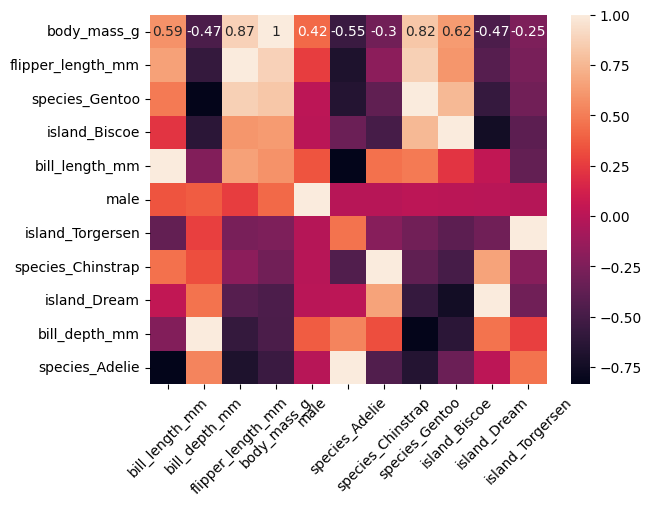

In [6]:
get_cors(df, target_col)

In [7]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [8]:
df = sns.load_dataset('penguins')

In [9]:
df.dropna(ignore_index=True, inplace=True)

Работает с категориальными переменными

In [10]:
def phik_cors(df, target_col):
    phik_overview = df.phik_matrix().round(2).sort_values(target_col)

    plot_correlation_matrix(phik_overview.values, 
                            x_labels=phik_overview.columns, 
                            y_labels=phik_overview.index, 
                            vmin=0, vmax=1, color_map="Greens", 
                            title=r"correlation phik", 
                            fontsize_factor=0.8, figsize=(11, 6))
    plt.xticks(rotation=45)

interval columns not set, guessing: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']


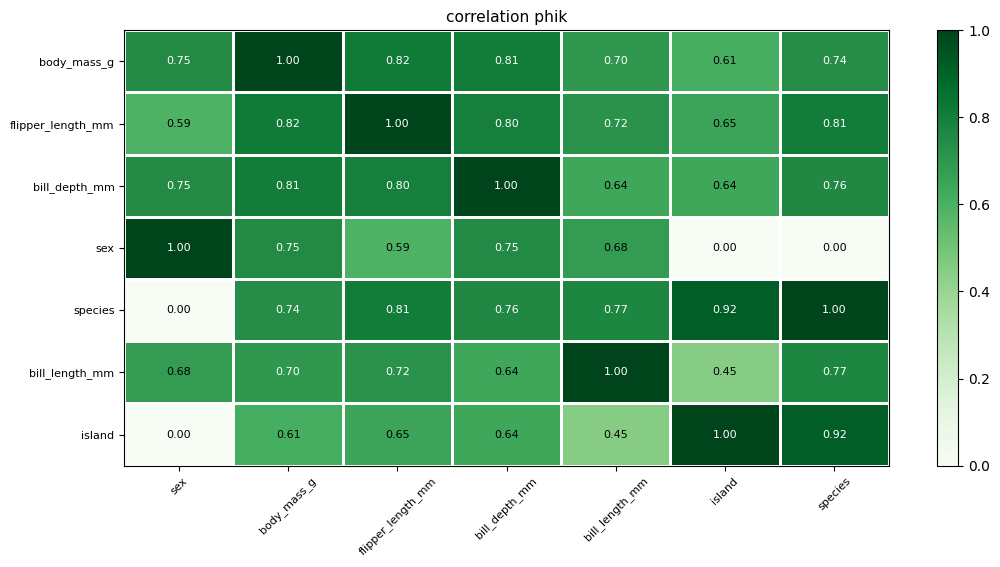

In [11]:
phik_cors(df, target_col)

Feauture importances

<h1>МЕНЯЕМ ЦЕЛЬ НА КЛАССИФИКАЦИЮ</h1>

In [12]:
target_col = 'species'

In [13]:
X = df.drop(target_col, axis=1)
y = df[target_col]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
cat_feat = ['island', 'sex']

In [16]:
best_model = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=8)
tr_dataset = Pool(X_train, y_train, cat_features=cat_feat)
test_dataset = Pool(X_test, y_test, cat_features=cat_feat)
best_model.fit(tr_dataset)

0:	learn: 1.0387184	total: 161ms	remaining: 32s
1:	learn: 0.9896888	total: 188ms	remaining: 18.6s
2:	learn: 0.9437276	total: 216ms	remaining: 14.2s
3:	learn: 0.8890016	total: 236ms	remaining: 11.5s
4:	learn: 0.8491416	total: 264ms	remaining: 10.3s
5:	learn: 0.8105351	total: 286ms	remaining: 9.26s
6:	learn: 0.7734481	total: 318ms	remaining: 8.77s
7:	learn: 0.7385420	total: 346ms	remaining: 8.31s
8:	learn: 0.7053395	total: 383ms	remaining: 8.12s
9:	learn: 0.6735544	total: 425ms	remaining: 8.07s
10:	learn: 0.6466274	total: 465ms	remaining: 7.99s
11:	learn: 0.6224830	total: 521ms	remaining: 8.17s
12:	learn: 0.5959373	total: 548ms	remaining: 7.88s
13:	learn: 0.5742538	total: 595ms	remaining: 7.9s
14:	learn: 0.5517444	total: 631ms	remaining: 7.79s
15:	learn: 0.5324432	total: 667ms	remaining: 7.67s
16:	learn: 0.5121923	total: 703ms	remaining: 7.56s
17:	learn: 0.4934765	total: 717ms	remaining: 7.25s
18:	learn: 0.4740865	total: 742ms	remaining: 7.06s
19:	learn: 0.4574473	total: 767ms	remaining:

In [17]:
def plot_imp(imp, tab):
    data = sorted([[imp[i], tab[i]] for i in range(len(imp))], key=lambda x: x[0], reverse=True)
    imp = [i[0] for i in data]
    tab = [i[1] for i in data]
    sns.barplot(x=imp, y=tab)

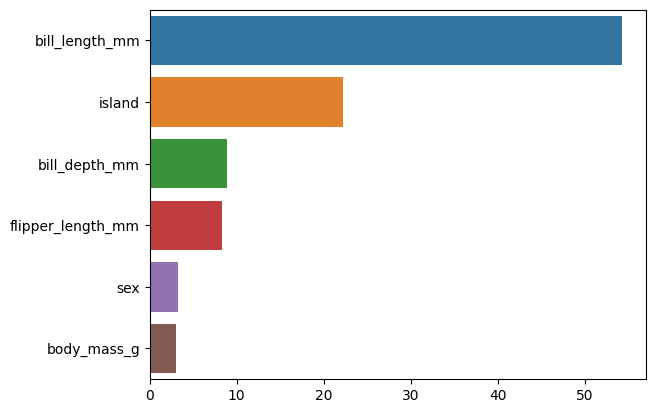

In [18]:
imp = best_model.feature_importances_
tab = X.columns
plot_imp(imp, tab)

In [19]:
from sklearn.inspection import permutation_importance

In [20]:
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=1066)

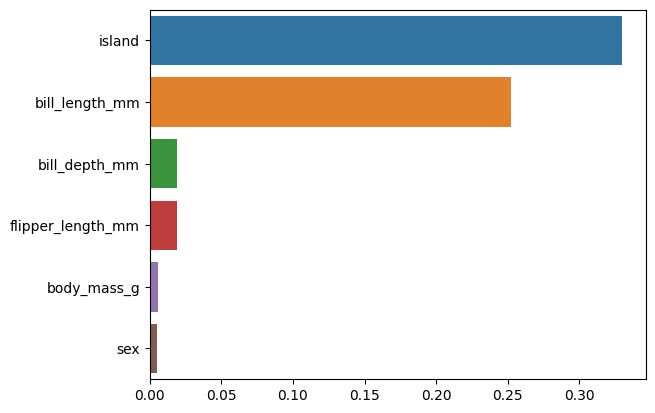

In [21]:
imp = perm_importance.importances_mean
plot_imp(imp, tab)

Shap

In [22]:
explainer = shap.TreeExplainer(best_model)

def shap_graph(explainer, val_dataset, X_test):
    shap_values = explainer.shap_values(val_dataset)
    shap.summary_plot(shap_values, X_test)

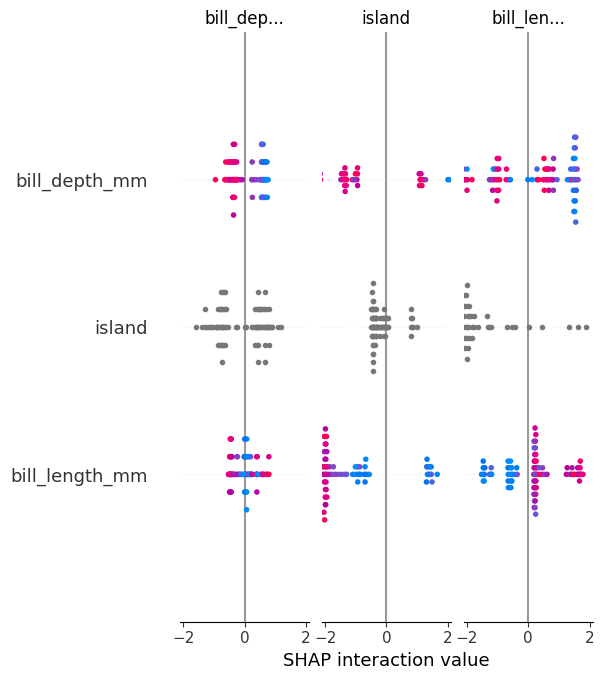

In [23]:
shap_graph(explainer, test_dataset, X_test)

Херня какая то

<h2>Путаньки модели</h2>

In [25]:
from sklearn.metrics import classification_report


y_pred = best_model.predict(X_test)
print(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=best_model.classes_))


              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        30
   Chinstrap       0.95      1.00      0.97        19
      Gentoo       1.00      1.00      1.00        35

    accuracy                           0.99        84
   macro avg       0.98      0.99      0.99        84
weighted avg       0.99      0.99      0.99        84



In [27]:
rep = pd.DataFrame(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=best_model.classes_,
                            output_dict=True)).T

In [28]:
rep

,precision,recall,f1-score,support
Adelie,1.000000,0.966667,0.983051,30.000000
Chinstrap,0.950000,1.000000,0.974359,19.000000
Gentoo,1.000000,1.000000,1.000000,35.000000
accuracy,0.988095,0.988095,0.988095,0.988095
macro avg,0.983333,0.988889,0.985803,84.000000
weighted avg,0.988690,0.988095,0.988147,84.000000


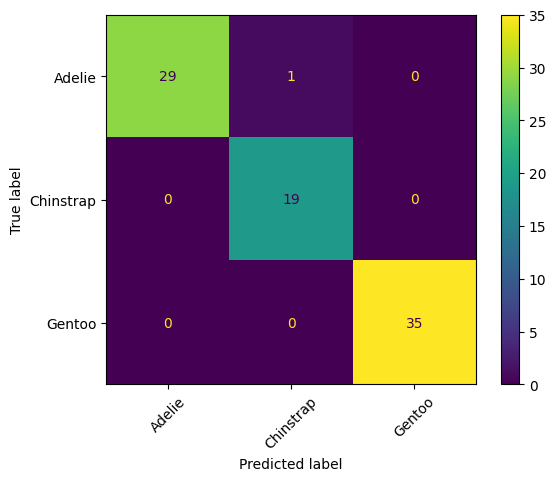

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, xticks_rotation = 45)

там где цифры не по диагонали там и путаница классов